In [1]:
#import libraries
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt 

#importing liabraries for graphical representation
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.cm import rainbow

Since the GPS coordinates are given in latitude/longitude format, I need to convert the data into meters using the following function

In [2]:
def distance(lat1, lat2, lon1, lon2): 
      
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the distance between two points 
    # 1609.344 is mutiplied to convert miles to meters
    return(c * r * 1609.344)

<b>Import Telematics Data</b>

In [3]:
travel = pd.read_csv('sample_trips.csv')
travelGroup = travel.groupby('trip_nb')
travel.head(5)

,trip_nb,local_dtm,latitude,longitude
0,1,19MAY17:07:33:59,40.037952,-83.071342
1,1,19MAY17:07:34:01,40.038181,-83.071274
2,1,19MAY17:07:34:02,40.038349,-83.071304
3,1,19MAY17:07:34:03,40.038448,-83.071266
4,1,19MAY17:07:34:04,40.038551,-83.071236


There are 16 trips. We specify the trip ID by a related varaibale and analyze a different trip in every run. I separate the trips using groupby.

In [10]:
trip_ID = 16 #sets the trip ID
thisTrip = travelGroup.get_group(trip_ID)
thisTrip.head()
thisTrip.reset_index(drop = True)

,trip_nb,local_dtm,latitude,longitude
0,16,23MAY17:19:54:49,40.031994,-83.116333
1,16,23MAY17:19:54:50,40.032001,-83.116318
2,16,23MAY17:19:54:51,40.032009,-83.116302
3,16,23MAY17:19:54:52,40.032009,-83.116302
4,16,23MAY17:19:54:53,40.032013,-83.116295
...,...,...,...,...
173,16,23MAY17:19:58:05,40.029373,-83.095665
174,16,23MAY17:19:58:07,40.029633,-83.095161
175,16,23MAY17:19:58:08,40.029678,-83.095093
176,16,23MAY17:19:58:09,40.029701,-83.094910


In [11]:
x = thisTrip['longitude']
y = thisTrip['latitude']
time = thisTrip['local_dtm']
# make series start from index = 0
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
time.reset_index(drop=True, inplace=True)
# coordinates of the origin
x0 = x[0]
y0 = y[0]

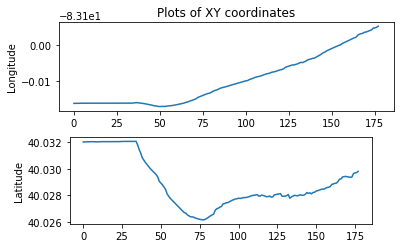

In [6]:
# plot X and Y coordinates to identify the outliers
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(211)
ax1.set_ylabel('Longitude')
ax1.set_title('Plots of XY coordinates')

ax1.plot(x)

# Fixing random state for reproducibility
np.random.seed(19680801)

ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.3])
ax2.set_ylabel('Latitude')

ax2.plot(y)

plt.show()

Convert coordinates to meters and measure X and Y distance from the origin x0,y0
Plotting the XY coordinates show that some trips have outlier GPS data and are way off intrems of value
Remove the outliers. Some trips such as #1 and #12 have very large outlier points 

In [7]:
y_meter = [0.0]
x_meter = [0.0]
t = [0.0]

for i in range(1,len(x)):
    yDis = distance(y0, y[i], x0, x[0]) 
    xDis = distance(y0, y[0], x0, x[i])
    delTime = 3600*(int(time[i][8:10]) - int(time[0][8:10])) + 60*(int(time[i][11:13]) - int(time[0][11:13])) + (int(time[i][14:16]) - int(time[0][14:16]))
    
    if (xDis > 1000000 or yDis > 1000000 or abs(delTime - t[len(t)-1]) < 0.5):
        continue
    else:
        x_meter.append(xDis)
        y_meter.append(yDis)
        t.append(delTime)

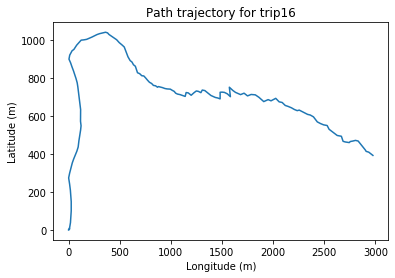

In [8]:
plt.xlabel('Longitude (m)')
plt.ylabel('Latitude (m)')
strTitle = 'Path trajectory for trip' + str(trip_ID)
plt.title(strTitle)
plt.plot(x_meter, y_meter)
plt.show()

<b> Calculate velocity and acceleration by taking the time derivatives: </b>

In [9]:
velocity = [0.0] * len(t)
accelerate = [0.0] * (len(t)-1)
velocity[0] = 0.0

for i in range(1,len(t)):
    dis = (x_meter[i] - x_meter[i-1])**2 + (y_meter[i] - y_meter[i-1])**2 
    velocity[i] = sqrt(dis) / (t[i] - t[i-1])
    accelerate[i-1] = (velocity[i] - velocity[i-1]) / (t[i] - t[i-1])

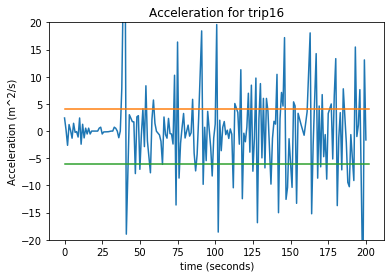

In [13]:
#plot accelartion
plt.xlabel('time (seconds)')
plt.ylabel('Acceleration (m^2/s)')
strTitle = 'Acceleration for trip' + str(trip_ID)
plt.title(strTitle)
plt.plot(t[0:len(t)-1], accelerate)
xAcc = [0,round(t[len(t)-1])]
yAcc = [0.41*9.8, 0.41*9.8]
plt.plot(xAcc, yAcc)
yAcc2 = [-0.61*9.8, -0.61*9.8]
plt.plot(xAcc, yAcc2)
plt.ylim([-20,20])
plt.show()

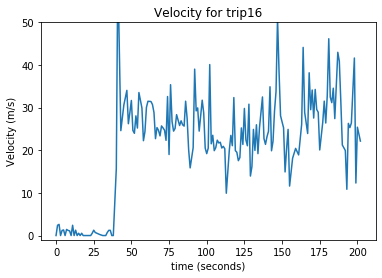

In [228]:
#plot accelartion
plt.xlabel('time (seconds)')
plt.ylabel('Velocity (m/s)')
strTitle = 'Velocity for trip' + str(trip_ID)
plt.title(strTitle)
plt.ylim([-1,50])
plt.plot(t, velocity)
plt.show()

<b> summary of the trip events </b> find out the number of hard events as well as idle time
We assume that the data velong to a passenger car and not a larger size vehicle. 
Threshold for hard braking = -0.61 G and for hard acceleration = 0.41 G
idling is defined as any data point with velocity < 0.5m/s

In [14]:
hardAcc = 0
hardBrake = 0
idlingTime = 0
DistanceTrvaled = 0
# define thresholds for hard events
THA = 0.41*9.81;
THB = -0.61*9.81;

for i in range(len(t)-1):
    
    if (accelerate[i] > THA and abs(velocity[i]) > 5.0):
        hardAcc += 1 
    if (accelerate[i] < THB and abs(velocity[i]) > 5.0):
        hardBrake += 1
    if (abs(velocity[i+1]) < 0.5):
        idlingTime += t[i+1] - t[i]
        
    DistanceTrvaled += sqrt((x_meter[i] - x_meter[i+1])**2 + (y_meter[i] - y_meter[i+1])**2)

In [15]:
print('Number of Hard Acceleration Events: ', hardAcc)
print('Number of Hard Brakes:              ', hardBrake)
print('Total Idling Time:                  ', idlingTime)
print('Total Distance Traveled (m):        ', DistanceTrvaled)

Number of Hrad Acceleration Events:  34
Number of Hrad Brake:                32
Total Idling Time:                   21
Total Distance Traveled (m):         4340.708855759825
